In [24]:
# Tutorial 2.9. Processing continuum Hamiltonians with discretize
# ===============================================================
#
# Physics background
# ------------------
#  - tight-binding approximation of continuous Hamiltonians
#
# Kwant features highlighted
# --------------------------
#  - kwant.continuum.discretize


import kwant
import kwant.continuum
import scipy.sparse.linalg
import scipy.linalg
import numpy as np

# For plotting
import matplotlib as mpl
from matplotlib import pyplot as plt


def stadium_system(L=20, W=20):
    hamiltonian = "k_x**2 + k_y**2 + V(x, y)"
    template = kwant.continuum.discretize(hamiltonian)
    print(template)

    def stadium(site):
        (x, y) = site.pos
        x = max(abs(x) - 20, 0)
        return x**2 + y**2 < 30**2

    syst = kwant.Builder()
    syst.fill(template, stadium, (0, 0));
    syst = syst.finalized()
    return syst


def plot_eigenstate(syst, n=4, Vx=.0003, Vy=.0005):

    def potential(x, y):
        return Vx * x + Vy * y

    ham = syst.hamiltonian_submatrix(params=dict(V=potential), sparse=True)
    evecs = scipy.sparse.linalg.eigsh(ham, k=10, which='SM')[1]
    eival = scipy.sparse.linalg.eigsh(ham, k=10, which='SM')[0]
    print("Eigenvalues: ", eival)
    kwant.plotter.map(syst, abs(evecs[:, n])**2, show=False)
    plt.show()


def qsh_system(a=20, L=2000, W=1000):
    hamiltonian = """
       + C * identity(4) + M * kron(sigma_0, sigma_z)
       - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z)
       - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
       + A * k_x * kron(sigma_z, sigma_x)
       - A * k_y * kron(sigma_0, sigma_y)
    """

    template = kwant.continuum.discretize(hamiltonian, grid=a)

    def shape(site):
        (x, y) = site.pos
        return (0 <= y < W and 0 <= x < L)

    def lead_shape(site):
        (x, y) = site.pos
        return (0 <= y < W)

    syst = kwant.Builder()
    syst.fill(template, shape, (0, 0))

    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
    lead.fill(template, lead_shape, (0, 0))

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    syst = syst.finalized()
    return syst


def analyze_qsh():
    params = dict(A=3.65, B=-68.6, D=-51.1, M=-0.01, C=0)
    syst = qsh_system()

    kwant.plotter.bands(syst.leads[0], params=params,
                        momenta=np.linspace(-0.3, 0.3, 201), show=False)

    plt.grid()
    plt.xlim(-.3, 0.3)
    plt.ylim(-0.05, 0.05)
    plt.xlabel('momentum [1/A]')
    plt.ylabel('energy [eV]')
    plt.show()
    # get scattering wave functions at E=0
    wf = kwant.wave_function(syst, energy=0, params=params)

    # prepare density operators
    sigma_z = np.array([[1, 0], [0, -1]])
    prob_density = kwant.operator.Density(syst, np.eye(4))
    spin_density = kwant.operator.Density(syst, np.kron(sigma_z, np.eye(2)))

    # calculate expectation values and plot them
    wf_sqr = sum(prob_density(psi) for psi in wf(0))  # states from left lead
    rho_sz = sum(spin_density(psi) for psi in wf(0))  # states from left lead

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
    kwant.plotter.map(syst, wf_sqr, ax=ax1)
    kwant.plotter.map(syst, rho_sz, ax=ax2)
    ax = ax1
    im = [obj for obj in ax.get_children()
          if isinstance(obj, mpl.image.AxesImage)][0]
    fig.colorbar(im, ax=ax)

    ax = ax2
    im = [obj for obj in ax.get_children()
          if isinstance(obj, mpl.image.AxesImage)][0]
    fig.colorbar(im, ax=ax)

    ax1.set_title('Probability density')
    ax2.set_title('Spin density')
    plt.show()


def lattice_spacing():
    hamiltonian = "k_x**2 * identity(2) + alpha * k_x * sigma_y"
    params = dict(alpha=.5)

    def plot(ax, a=1):
        h_k = kwant.continuum.lambdify(hamiltonian, locals=params)
        k_cont = np.linspace(-4, 4, 201)
        e_cont = [scipy.linalg.eigvalsh(h_k(k_x=ki)) for ki in k_cont]

        template = kwant.continuum.discretize(hamiltonian, grid=a)
        syst = kwant.wraparound.wraparound(template).finalized()

        def h_k(k_x):
            p = dict(k_x=k_x, **params)
            return syst.hamiltonian_submatrix(params=p)

        k_tb = np.linspace(-np.pi/a, np.pi/a, 201)
        e_tb = [scipy.linalg.eigvalsh(h_k(k_x=a*ki)) for ki in k_tb]

        ax.plot(k_cont, e_cont, 'r-')
        ax.plot(k_tb, e_tb, 'k-')

        ax.plot([], [], 'r-', label='continuum')
        ax.plot([], [], 'k-', label='tight-binding')

        ax.set_xlim(-4, 4)
        ax.set_ylim(-1, 14)
        ax.set_title('a={}'.format(a))

        ax.set_xlabel('momentum [a.u.]')
        ax.set_ylabel('energy [a.u.]')
        ax.grid()
        ax.legend()

    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

    plot(ax1, a=1)
    plot(ax2, a=.25)
    plt.show()


def substitutions():
    sympify = kwant.continuum.sympify
    subs = {'sx': [[0, 1], [1, 0]], 'sz': [[1, 0], [0, -1]]}

    e = (
        sympify('[[k_x**2, alpha * k_x], [k_x * alpha, -k_x**2]]'),
        sympify('k_x**2 * sigma_z + alpha * k_x * sigma_x'),
        sympify('k_x**2 * sz + alpha * k_x * sx', locals=subs),
    )

    print(e[0] == e[1] == e[2])

    subs = {'A': 'A(x) + B', 'V': 'V(x) + V_0', 'C': 5}
    print(sympify('k_x * A * k_x + V + C', locals=subs))






# Discrete coordinates: x

# Onsite element:
def onsite(site, A):
    (x, ) = site.pos
    _const_0 = (A(0.5 + x))
    _const_1 = (A(-0.5 + x))
    return (1.0*_const_0 + 1.0*_const_1)

# Hopping from (1,):
def hopping_1(site1, site2, A):
    (x, ) = site1.pos
    _const_0 = (A(0.5 + x))
    return (-1.0*_const_0)
# Discrete coordinates: x y

# Onsite element:
def onsite(site, V):
    (x, y, ) = site.pos
    _const_0 = (V(x, y))
    return (_const_0 + 4.0)

# Hopping from (1, 0):
(-1+0j)

# Hopping from (0, 1):
(-1+0j)
Eigenvalues:  [-0.00321487  0.00419101  0.00875145  0.01132562  0.01623879  0.01906593
  0.02300618  0.02386176  0.02848594  0.03089072]


<ipython-input-24-cc86527c3c60>:49: RuntimeWarning: The plotted data contains 1.51% of values overflowing upper limit 0.000943202 
  kwant.plotter.map(syst, abs(evecs[:, n])**2, show=False)


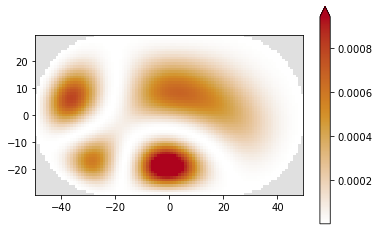

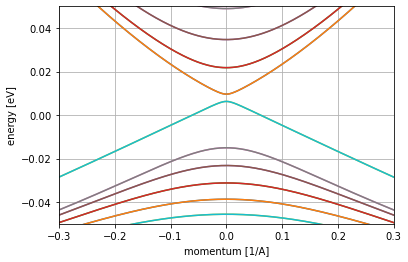

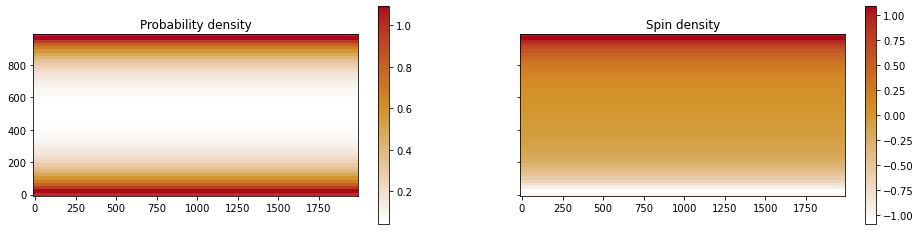

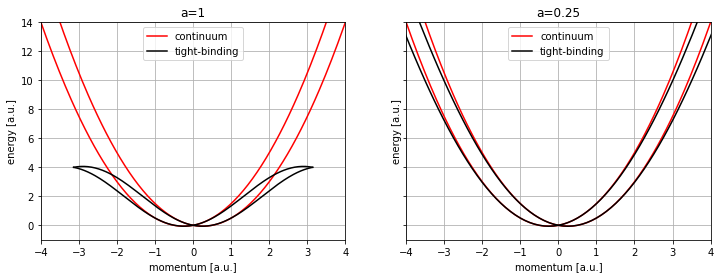

True
V_0 + 5 + k_x*(B + A(x))*k_x + V(x)


In [25]:
def main():
    template = kwant.continuum.discretize('k_x * A(x) * k_x')
    print(template)

    syst = stadium_system()
    plot_eigenstate(syst)

    analyze_qsh()
    lattice_spacing()
    substitutions()

# Call the main function if the script gets executed (as opposed to imported).
# See <http://docs.python.org/library/__main__.html>.
if __name__ == '__main__':
    main()

In [9]:
import kwant
import kwant.continuum
import scipy.sparse.linalg
import scipy.linalg
import numpy as np

hamiltonian = "k_x**2 + k_y**2 + V(x, y)"
# template = kwant.continuum.discretize(hamiltonian)
template = kwant.continuum.discretize('k_x * A(x) * k_x')
print(template)

# Discrete coordinates: x

# Onsite element:
def onsite(site, A):
    (x, ) = site.pos
    _const_0 = (A(0.5 + x))
    _const_1 = (A(-0.5 + x))
    return (1.0*_const_0 + 1.0*_const_1)

# Hopping from (1,):
def hopping_1(site1, site2, A):
    (x, ) = site1.pos
    _const_0 = (A(0.5 + x))
    return (-1.0*_const_0)


In [11]:
syst = stadium_system()

# Discrete coordinates: x y

# Onsite element:
def onsite(site, V):
    (x, y, ) = site.pos
    _const_0 = (V(x, y))
    return (_const_0 + 4.0)

# Hopping from (1, 0):
(-1+0j)

# Hopping from (0, 1):
(-1+0j)


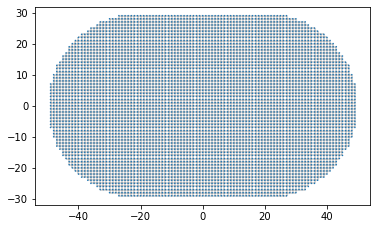

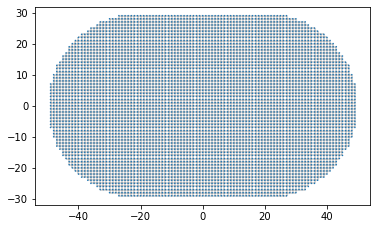

In [12]:
kwant.plot(syst)